In [94]:
from typing import Tuple, List, Union, Any, Optional, Dict, Literal, Callable, Type
import abc

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim
import torch.utils.data
from torch import Tensor
import matplotlib.pyplot as plt

from models.ridge_ALOOCV import fit_ridge_ALOOCV
from models.sandwiched_least_squares import sandwiched_LS_dense, sandwiched_LS_diag, sandwiched_LS_scalar

def acc_from_logits(logits, y, n_classes):
    if n_classes==2:
        pred = (logits>0).float()
    else:
        pred = torch.argmax(logits, dim=1)
        y = torch.argmax(y, dim=1)
    acc = (pred==y).float().mean()
    return acc



def generate_concentric_rings(n_rings_per_class=2, n_classes=3, n_samples=2000, device="cpu", plot=False) -> Tuple[np.ndarray, np.ndarray]:
    X = []
    y = []
    n_rings = n_rings_per_class * n_classes
    samples_per_ring = n_samples // n_rings
    for i in range(n_rings):
        radius = i + 1
        theta = np.linspace(0, 2 * np.pi, samples_per_ring)
        noise_scale = 0.5
        x1 = radius * np.cos(theta) + np.random.rand(samples_per_ring) * noise_scale
        x2 = radius * np.sin(theta) + np.random.rand(samples_per_ring) * noise_scale
        X.append(np.vstack((x1, x2)).T)
        y.append(np.full(samples_per_ring, i % n_classes))
    X = np.vstack(X)
    y = np.hstack(y)
    perm = np.random.permutation(len(X))
    X = X[perm] / np.max(X)
    y = y[perm]

    #plot
    if plot:
        plt.figure(figsize=(8, 8))
        for i in range(n_classes):
            plt.scatter(X[y == i][:, 0], X[y == i][:, 1], label=f'Class {i}')
        plt.legend()
        plt.title('Concentric Rings Dataset')
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.show()

    y = torch.tensor(y).float()
    X = torch.tensor(X).float()
    if n_classes > 2:
        y = torch.nn.functional.one_hot(y.to(torch.int64), n_classes).float()
    else:
        y = y.unsqueeze(1)

    r = int(0.5 * len(X))
    X_train, y_train, X_test, y_test = X[:r], y[:r], X[r:], y[r:]
    return (X_train.to(device),
            y_train.to(device), 
            X_test.to(device), 
            y_test.to(device) )




# Generate dataset
# n_classes = 2
# D = 10
# X_train, y_train, X_test, y_test = make_spirals_dataset_Rd(
#     n_samples=1000, n_classes=n_classes, noise=0.1, D=D, train_test_ratio=0.8
#     )
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
n_classes = 3
D = 2
device = "cpu"
X_train, y_train, X_test, y_test = generate_concentric_rings(
    n_rings_per_class=3, n_classes=n_classes, n_samples=6000, device=device
    )
if n_classes > 2:
    loss_fn = nn.functional.cross_entropy
else:
    loss_fn = nn.functional.binary_cross_entropy_with_logits

In [48]:
from models.base import LogisticRegression
    
model = LogisticRegression(
    n_classes, l2_lambda=0.1, max_iter=100
     )

results = []
for i in range(5):
    model.fit(X_train, y_train)
    out_train = model(X_train)
    out_test = model(X_test)
    ce_train = loss_fn(out_train, y_train)
    ce_test = loss_fn(out_test, y_test)
    acc_train = acc_from_logits(out_train, y_train, n_classes)
    acc_test = acc_from_logits(out_test, y_test, n_classes)
    results.append(torch.tensor([ce_train, ce_test, acc_train, acc_test]))
results = torch.stack(results)
print("train ce", results[:, 0].mean(), "std", results[:, 0].std())
print("test ce", results[:, 1].mean(), "std", results[:, 1].std())
print("train acc", results[:, 2].mean(), "std", results[:, 2].std())
print("test acc", results[:, 3].mean(), "std", results[:, 3].std())

train ce tensor(1.09772598743438720703) std tensor(1.03238271265126968501e-07)
test ce tensor(1.10055351257324218750) std tensor(1.34738138513057492673e-06)
train acc tensor(0.33947896957397460938) std tensor(0.00179244321770966053)
test acc tensor(0.31879997253417968750) std tensor(0.00178885797504335642)


In [100]:
#from models.random_feature_representation_boosting import GradientRFRBoostClassifier
from models.random_feature_representation_boosting import GradientRFRBoostClassifier

seed=2
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

model = GradientRFRBoostClassifier(
        in_dim=D,
        n_classes=n_classes,
        hidden_dim=2,
        n_layers=4,
        randfeat_xt_dim=512,
        randfeat_x0_dim=512,
        l2_cls=0.001,
        l2_ghat=0.0001,
        boost_lr=1.0,
        feature_type="SWIM",
        upscale_type="identity",
        lbfgs_lr=1.0,
        lbfgs_max_iter=300,
        use_batchnorm=True,
        SWIM_scale = -1.0,
        activation = nn.ReLU(),
    )

results = []
for i in range(1):
    model.fit(X_train, y_train)
    out_train = model(X_train)
    out_test = model(X_test)
    ce_train = loss_fn(out_train, y_train)
    ce_test = loss_fn(out_test, y_test)
    acc_train = acc_from_logits(out_train, y_train, n_classes)
    acc_test = acc_from_logits(out_test, y_test, n_classes)
    results.append(torch.tensor([ce_train, ce_test, acc_train, acc_test]))
results = torch.stack(results)
print("train ce", results[:, 0].mean(), "std", results[:, 0].std())
print("test ce", results[:, 1].mean(), "std", results[:, 1].std())
print("train acc", results[:, 2].mean(), "std", results[:, 2].std())
print("test acc", results[:, 3].mean(), "std", results[:, 3].std())

train ce tensor(0.01062060240656137466) std tensor(nan)
test ce tensor(0.02638900652527809143) std tensor(nan)
train acc tensor(1.) std tensor(nan)
test acc tensor(0.99566233158111572266) std tensor(nan)


/tmp/ipykernel_14382/3401158833.py:39: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1808.)
  print("train ce", results[:, 0].mean(), "std", results[:, 0].std())
/tmp/ipykernel_14382/3401158833.py:40: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1808.)
  print("test ce", results[:, 1].mean(), "std", results[:, 1].std())
/tmp/ipykernel_14382/3401158833.py:41: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1808.)
  print("train acc", results[:, 2].mean(), "std", results[:, 2].std())
/tmp/ipykernel_1438

Train ce at layer 0: 1.0970791578292847
Test ce at layer 0: 1.1034345626831055
Train acc at layer 0: 0.3166332542896271
Test acc at layer 0: 0.2720000147819519



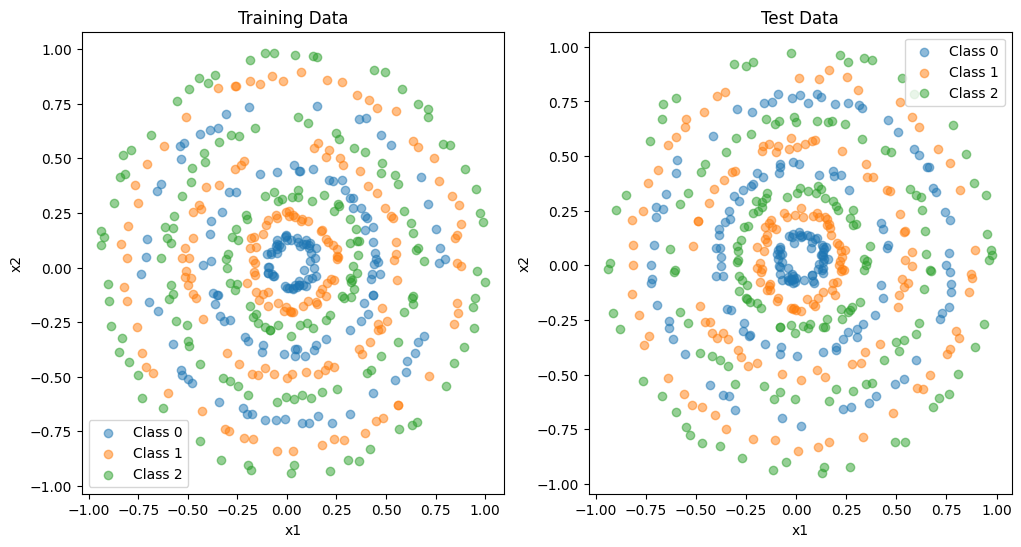

Train ce at layer 1: 0.044253189116716385
Test ce at layer 1: 0.5943604111671448
Train acc at layer 1: 0.9799599051475525
Test acc at layer 1: 0.843999981880188



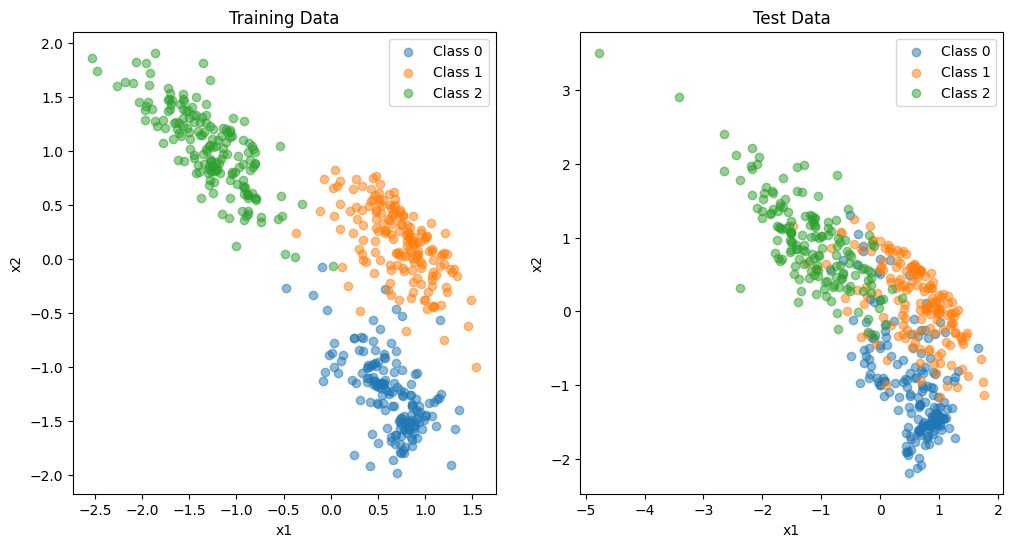

Train ce at layer 2: 0.008267869241535664
Test ce at layer 2: 0.6253412961959839
Train acc at layer 2: 1.0
Test acc at layer 2: 0.8740000128746033



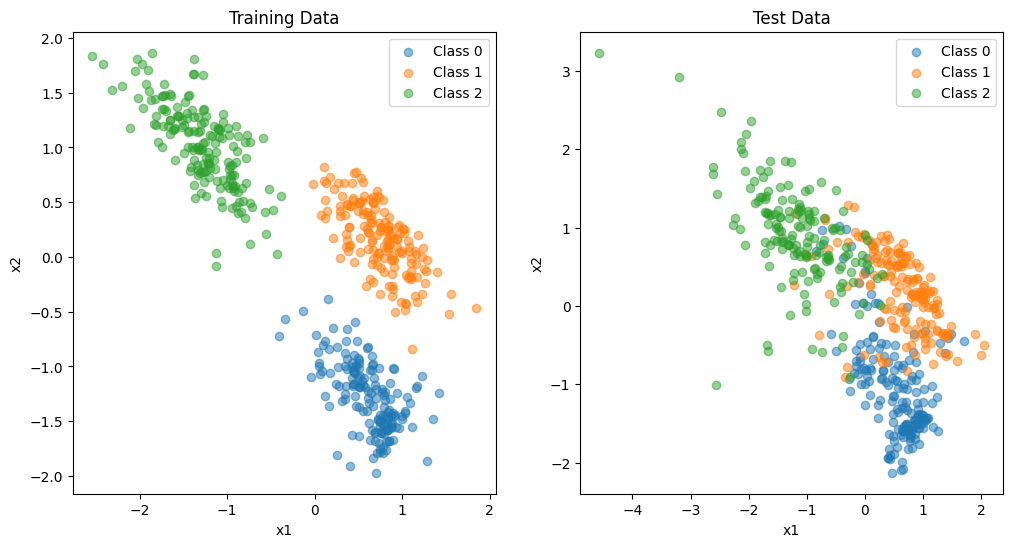

Train ce at layer 3: 0.004258432891219854
Test ce at layer 3: 0.5677638053894043
Train acc at layer 3: 1.0
Test acc at layer 3: 0.8799999952316284



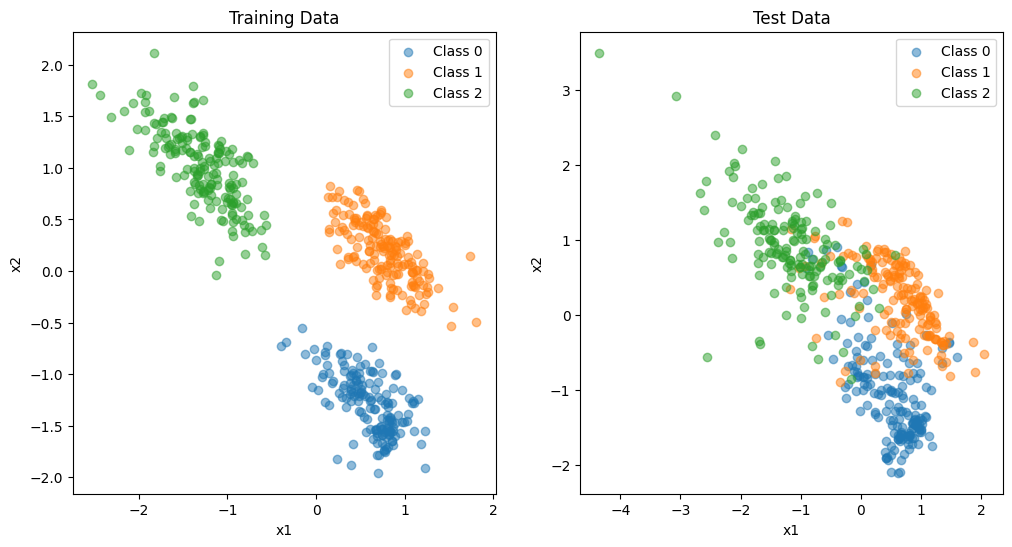

Train ce at layer 4: 0.0031664979178458452
Test ce at layer 4: 0.5342385768890381
Train acc at layer 4: 1.0
Test acc at layer 4: 0.8759999871253967



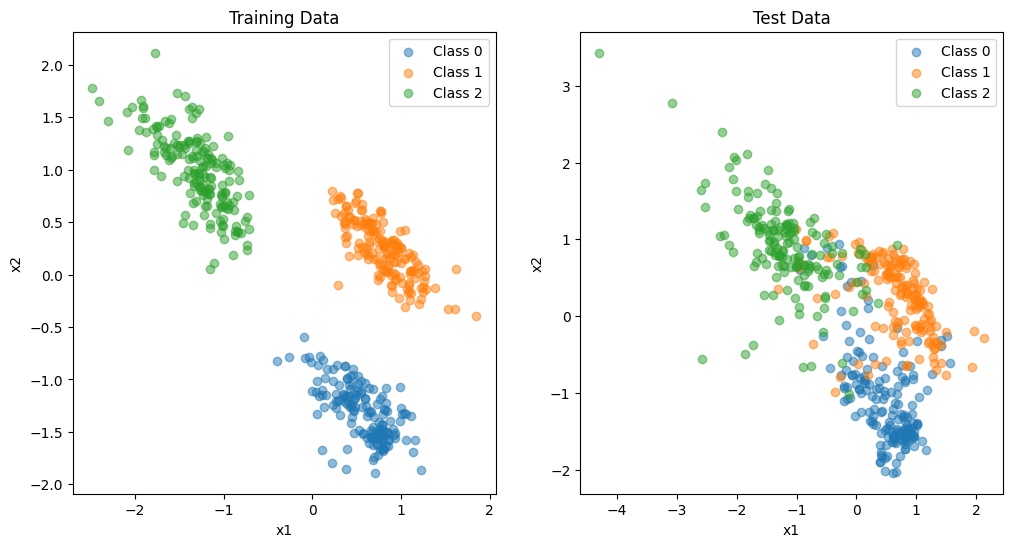

In [61]:
def plot_features(X_train, y_train, X_test, y_test):
        plt.figure(figsize=(12, 6))

        if y_train.size(1) == 1:
            y_train = torch.nn.functional.one_hot(y_train[:, 0].to(torch.int64), 2).float()
            y_test = torch.nn.functional.one_hot(y_test[:, 0].to(torch.int64), 2).float()

        X_train = X_train.cpu().numpy()
        y_train = y_train.cpu().numpy()
        X_test = X_test.cpu().numpy()
        y_test = y_test.cpu().numpy()

        alpha = 0.5  # Set the transparency level

        plt.subplot(1, 2, 1)
        for i in range(n_classes):
            plt.scatter(X_train[y_train[:, i] == 1][:, 0], X_train[y_train[:, i] == 1][:, 1], label=f'Class {i}', alpha=alpha)
        plt.title('Training Data')
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.legend()

        plt.subplot(1, 2, 2)
        for i in range(n_classes):
            plt.scatter(X_test[y_test[:, i] == 1][:, 0], X_test[y_test[:, i] == 1][:, 1], label=f'Class {i}', alpha=alpha)
        plt.title('Test Data')
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.legend()

        plt.show()


def see_results_for_every_layer(X_train, y_train, X_test, y_test, model, loss_fn):
    with torch.no_grad():
        X0_train = X_train
        X0_test = X_test

        X_train = model.upscale(X0_train)
        X_test = model.upscale(X0_test)

        pred_train = model.top_level_modules[0](X_train)
        pred_test = model.top_level_modules[0](X_test)

        ce_train = loss_fn(pred_train, y_train)
        ce_test = loss_fn(pred_test, y_test)
        acc_train = acc_from_logits(pred_train, y_train, n_classes)
        acc_test = acc_from_logits(pred_test, y_test, n_classes)
        print(f"Train ce at layer 0: {ce_train}")
        print(f"Test ce at layer 0: {ce_test}")
        print(f"Train acc at layer 0: {acc_train}")
        print(f"Test acc at layer 0: {acc_test}")
        print()
        plot_features(X_train, y_train, X_test, y_test)
        
        for t, (feat_layer, ghat_layer, classifier, batchnorm) in enumerate(zip(model.random_feature_layers, 
                                                                     model.ghat_boosting_layers, 
                                                                     model.top_level_modules[1:],
                                                                     model.batchnorms)):
            features_train = feat_layer(X_train, X0_train)
            features_test = feat_layer(X_test, X0_test)
            X_train = X_train + model.boost_lr * ghat_layer(features_train)
            X_train = batchnorm(X_train)
            X_test = X_test + model.boost_lr * ghat_layer(features_test)
            X_test = batchnorm(X_test)
            
            pred_train = classifier(X_train)
            pred_test = classifier(X_test)

            ce_train = loss_fn(pred_train, y_train)
            ce_test = loss_fn(pred_test, y_test)
            acc_train = acc_from_logits(pred_train, y_train, n_classes)
            acc_test = acc_from_logits(pred_test, y_test, n_classes)

            print(f"Train ce at layer {t+1}: {ce_train}")
            print(f"Test ce at layer {t+1}: {ce_test}")
            print(f"Train acc at layer {t+1}: {acc_train}")
            print(f"Test acc at layer {t+1}: {acc_test}")
            print()
            plot_features(X_train, y_train, X_test, y_test)

see_results_for_every_layer(X_train, y_train, X_test, y_test, model, loss_fn)


# End2End

In [80]:
from models.end2end import End2EndMLPResNet

n_blocks = 4
model = End2EndMLPResNet(
        in_dim=2,
        hidden_dim=2,
        bottleneck_dim=512,
        out_dim= (n_classes if n_classes>2 else 1),
        n_blocks=n_blocks,
        loss = ("cce" if n_classes>2 else "bce"),
        lr = 0.001,
        n_epochs = 30,
        end_lr_factor= 0.01,
        weight_decay = 0.00001,
        batch_size = 128,
        upsample = False,
        activation = nn.ReLU(),
        )

results = []
for i in range(1):
    model.fit(X_train, y_train)
    model.eval()
    out_train = model(X_train)
    out_test = model(X_test)
    ce_train = loss_fn(out_train, y_train)
    ce_test = loss_fn(out_test, y_test)
    acc_train = acc_from_logits(out_train, y_train, n_classes)
    acc_test = acc_from_logits(out_test, y_test, n_classes)
    results.append(torch.tensor([ce_train, ce_test, acc_train, acc_test]))
results = torch.stack(results)
print("train ce", results[:, 0].mean(), "std", results[:, 0].std())
print("test ce", results[:, 1].mean(), "std", results[:, 1].std())
print("train acc", results[:, 2].mean(), "std", results[:, 2].std())
print("test acc", results[:, 3].mean(), "std", results[:, 3].std())

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:00<00:00, 42.08it/s]

train ce tensor(1.13191676139831542969) std tensor(nan)
test ce tensor(1.14356040954589843750) std tensor(nan)
train acc tensor(0.33466935157775878906) std tensor(nan)
test acc tensor(0.33199998736381530762) std tensor(nan)



/tmp/ipykernel_14382/3186377228.py:32: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1808.)
  print("train ce", results[:, 0].mean(), "std", results[:, 0].std())
/tmp/ipykernel_14382/3186377228.py:33: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1808.)
  print("test ce", results[:, 1].mean(), "std", results[:, 1].std())
/tmp/ipykernel_14382/3186377228.py:34: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1808.)
  print("train acc", results[:, 2].mean(), "std", results[:, 2].std())
/tmp/ipykernel_143

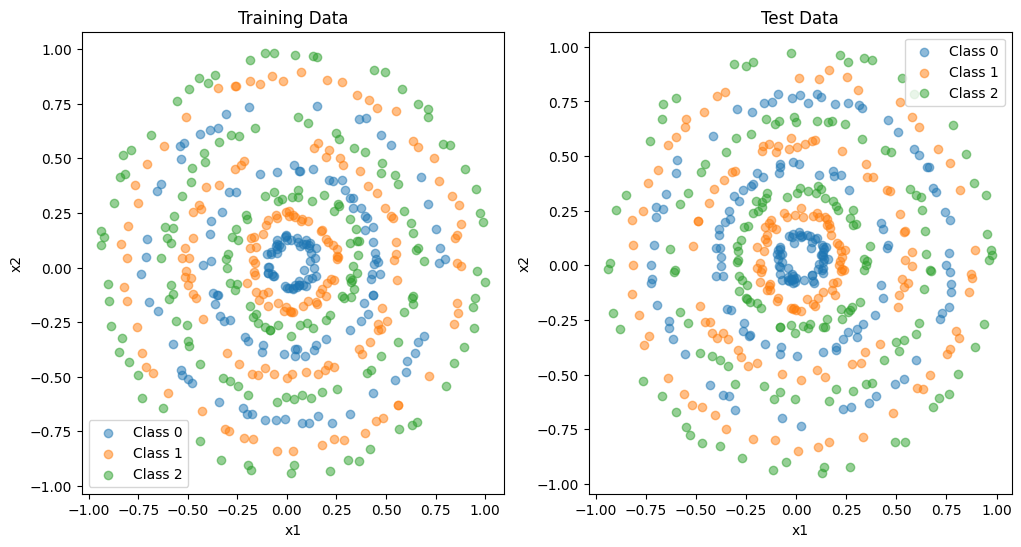

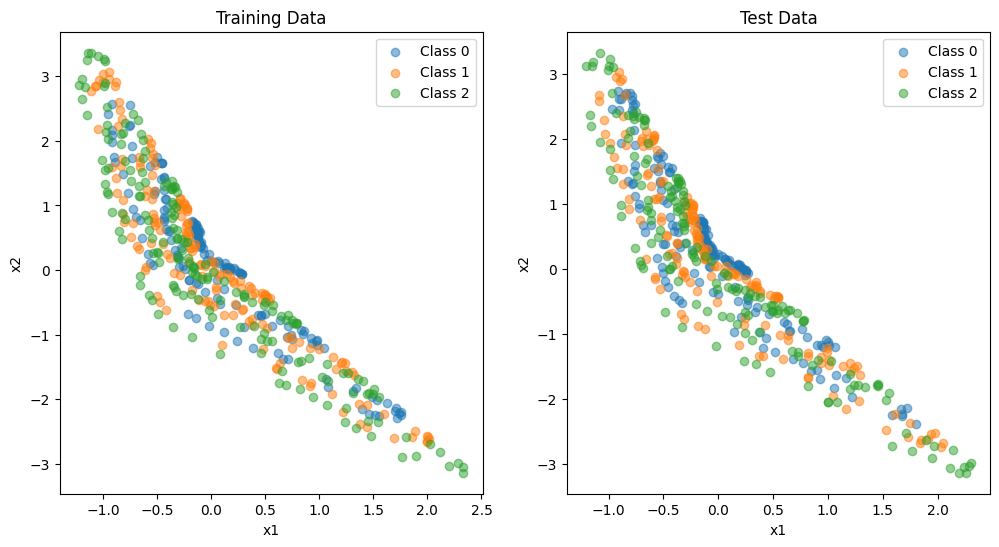

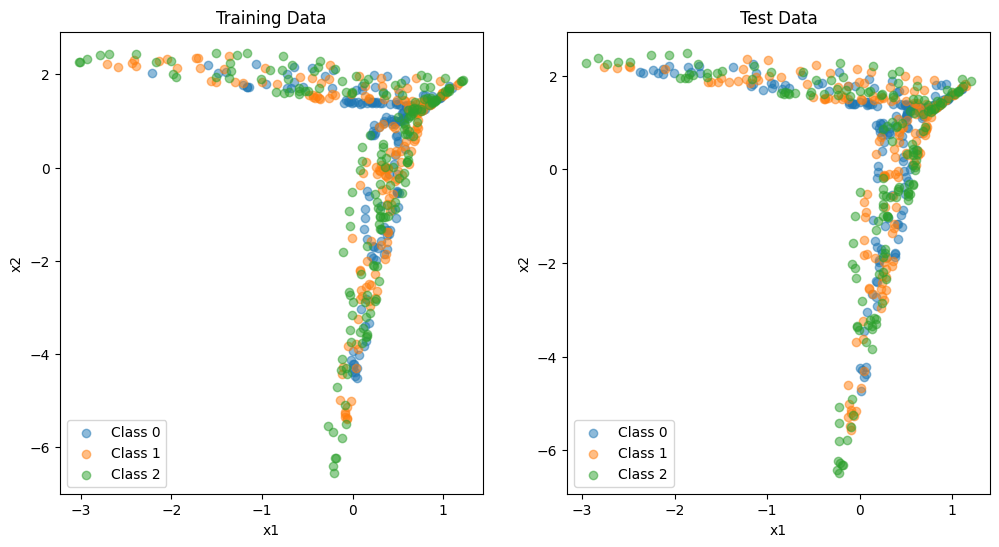

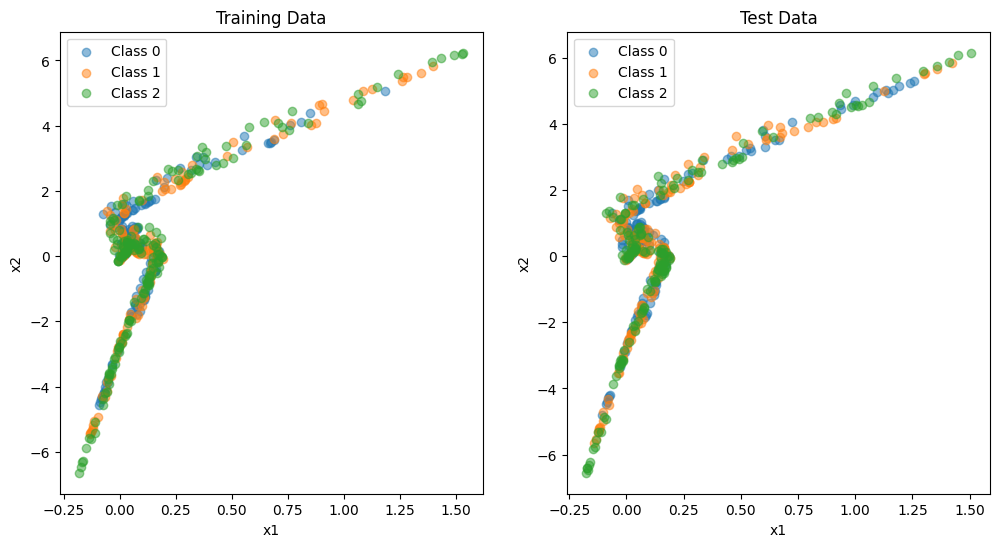

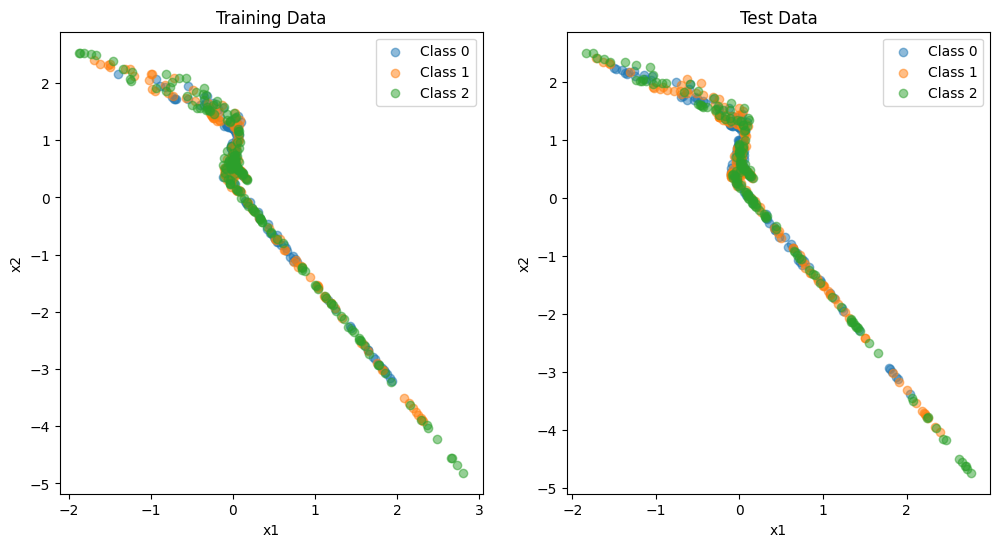

In [81]:
def plot_resnet(X_train, y_train, X_test, y_test, model):
    with torch.no_grad():
        # for each layer, calculate the activations, and plot
        X_train = model.upsample(X_train)
        X_test = model.upsample(X_test)
        plot_features(X_train, y_train, X_test, y_test)

        for t in range(n_blocks):
            X_train = X_train + model.residual_blocks[t](X_train)
            X_test = X_test + model.residual_blocks[t](X_test)
            plot_features(X_train, y_train, X_test, y_test)
plot_resnet(X_train, y_train, X_test, y_test, model)

# How do i want to set up the experiments?

In [102]:
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from models.base import FittableModule

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

class SKLearnWrapper(BaseEstimator):
    def __init__(self, modelClass=None, **model_params):
        self.modelClass = modelClass
        self.model_params = model_params
        self.seed = None
        self.model = None

    def fit(self, X, y):
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        torch.cuda.manual_seed(self.seed)

        self.model = self.modelClass(**self.model_params)
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def set_params(self, **params):
        self.modelClass = params.pop('modelClass', self.modelClass)
        self.seed = params.pop('seed', self.seed)
        self.model_params.update(params)
        return self

    def get_params(self, deep=True):
        params = {'modelClass': self.modelClass}
        params.update(self.model_params)
        return params
    
    def score(self, X, y):
        logits = self.model(X)
        if y.size(1) == 1:
            pred = (logits>0).float()
        else:
            pred = torch.argmax(logits, dim=1)
            y = torch.argmax(y, dim=1)
        acc = (pred==y).float().mean()
        print(acc)
        return acc.detach().cpu().item()
    
    def set_model_eval(self):
        self.model.eval()
    

import matplotlib.patches as patches

def save_feature_plot(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        model, 
        n_classes, 
        file_name: str,
        save_dir: str = "save/ConcentricCircles/"
        ):
    """
    Saves train and test features side by side for visualization at a given layer.
    
    Args:
        X_train (torch.Tensor): Features of the training set (shape: [n_samples, 2]).
        y_train (torch.Tensor): Labels of the training set (one-hot or integer-encoded).
        X_test (torch.Tensor): Features of the test set (shape: [n_samples, 2]).
        y_test (torch.Tensor): Labels of the test set (one-hot or integer-encoded).
        n_classes (int): Number of classes in the dataset.
        file_name (str): Name of the file to save the plot.
        save_dir (str): Directory to save the plot.
    """
    # Obtain the features at each layer
    train_features = [X_train]
    test_features = [X_test]
    if type(model) == GradientRFRBoostClassifier:
        X0_train = X_train
        X0_test = X_test
        for t, (feat_layer, ghat_layer, batchnorm) in enumerate(zip(model.random_feature_layers, 
                                                                     model.ghat_boosting_layers, 
                                                                     model.batchnorms)):
            model.train()
            features_train = feat_layer(X_train, X0_train)
            X_train = X_train + model.boost_lr * ghat_layer(features_train)
            X_train = batchnorm(X_train)
            model.eval()
            features_test = feat_layer(X_test, X0_test)
            X_test = X_test + model.boost_lr * ghat_layer(features_test)
            X_test = batchnorm(X_test)
            train_features.append(X_train)
            test_features.append(X_test)
    elif type(model) == End2EndMLPResNet:
        for resblock in model.residual_blocks:
            X_train = X_train + resblock(X_train)
            X_test = X_test + resblock(X_test)
            train_features.append(X_train)
            test_features.append(X_test)
    else:
        raise ValueError("Model type not recognized.")
    
    # Convert labels to integers if they're one-hot encoded
    train_labels_np = y_train.argmax(dim=1).cpu().numpy() if n_classes > 2 else y_train.cpu().numpy()
    test_labels_np = y_test.argmax(dim=1).cpu().numpy() if n_classes > 1 else y_test.cpu().numpy()


    # Plot the features
    T = len(train_features)
    for name_train_or_test, features, labels in [("train", train_features, train_labels_np), 
                                                 ("test", test_features, test_labels_np)]:
        fig, axes = plt.subplots(1, T, figsize=(T * 4, 4), dpi=100)
        for t in range(T):
            ax = axes[t]
            feat = features[t].detach().cpu().numpy()
            for j in range(feat.shape[1]):
                feat[:, j] = (feat[:, j] - feat[:, j].min()) / (feat[:, j].max() - feat[:, j].min())
            for i in range(n_classes):
                ax.scatter(feat[labels == i][:, 0], feat[labels == i][:, 1])

            # Remove titles and adjust axis
            ax.axis('equal')
            ax.axis('off')

            # Add black border as a rectangle
            rect = patches.Rectangle(
                (0, 0), 1, 1, transform=ax.transAxes,  # Set size relative to axes
                linewidth=2, edgecolor='black', facecolor='none', zorder=10
            )
            ax.add_patch(rect)

        # Add vertical label for the model name
        name = "MLP ResNet" if type(model) == End2EndMLPResNet else "GRFRBoost (ours)"
        if "GRFRBoost" in name:
            if model.randfeat_x0_dim == 0:
                name += " x0 only"
            if model.feature_type == "SWIM":
                name += " SWIM"
        fig.text(0.02, 0.5, name, fontsize=18, rotation='vertical', va='center', ha='center')

        plt.tight_layout()
        plt.subplots_adjust(left=0.03)  # Add space for the model name
        plt.savefig(f"{save_dir}/{file_name}_{name_train_or_test}.png", bbox_inches='tight', dpi=300)
        plt.close(fig)



def run_concentric_rings_experiment(
        seed=42,
        k_folds=5,
        n_classes=3,
        n_rings_per_class=3,
        n_samples=5000,
        device="cpu",
        ):
    """Runs the concentric circle experiments and saves the plots and results."""
    # Define models and their hyperparameter grids
    n_layers = 4 # TODO CHANGE
    bottleneck_dim = 512
    use_batchnorm = True
    model_specs = {
        "RFRBoost SWIM": {
            'modelClass': [GradientRFRBoostClassifier],
            'l2_cls': np.logspace(-4, 0, 5),
            'l2_ghat': np.logspace(-4, 0, 5),
            'in_dim': [2],
            'n_classes': [n_classes],
            'hidden_dim': [2],
            'n_layers': [n_layers],
            'randfeat_xt_dim': [bottleneck_dim],
            'randfeat_x0_dim': [bottleneck_dim],
            'feature_type': ["SWIM"],
            'upscale_type': ["identity"],
            'use_batchnorm': [use_batchnorm],
            'lbfgs_max_iter': [300],
            'lbfgs_lr': [1.0],
            'SWIM_scale': [-0.5],
            'activation': [nn.ReLU()],
        },
        "RFRBoost iid": {
            'modelClass': [GradientRFRBoostClassifier],
            'l2_cls': np.logspace(-4, 0, 5),
            'l2_ghat': np.logspace(-4, 0, 5),
            'in_dim': [2],
            'n_classes': [n_classes],
            'hidden_dim': [2],
            'n_layers': [n_layers],
            'randfeat_xt_dim': [bottleneck_dim],
            'randfeat_x0_dim': [bottleneck_dim],
            'feature_type': ["iid"],
            'upscale_type': ["identity"],
            'use_batchnorm': [use_batchnorm],
            'lbfgs_max_iter': [300],
            'lbfgs_lr': [1.0],
            'iid_scale': [1.0],
            'activation': [nn.ReLU()],
        },
        "Logistic Regression": {
            'modelClass': [LogisticRegression],
            'l2_lambda': np.logspace(-4, -1, 4),
            'n_classes': [n_classes],
        },
        "End2EndMLP": {
            'modelClass': [End2EndMLPResNet],
            'lr': np.logspace(-6, -1, 6),
            'in_dim': [2],
            'hidden_dim': [2],
            'bottleneck_dim': [bottleneck_dim],
            'out_dim': [n_classes if n_classes > 2 else 1],
            'n_blocks': [n_layers],
            'loss': ["cce" if n_classes > 2 else "bce"],
            'n_epochs': [30],
            'end_lr_factor': [0.01],
            'weight_decay': [0.00001],
            'batch_size': [64],
            'upsample': [False],
            'activation': [nn.ReLU()],
        },
    }

    # Run experiments
    results = {}
    results_params = {}
    for model_name, param_grid in model_specs.items():
        accuracies = []
        best_params = []
        for i in range(1):
            # Set seed
            np.random.seed(seed+i)
            torch.manual_seed(seed+i)
            torch.cuda.manual_seed(seed+i)

            # Create dataset
            X_train, y_train, X_test, y_test = generate_concentric_rings(
                n_rings_per_class, n_classes, n_samples, device
            )

            # Perform grid search with k-fold cross-validation
            estimator = SKLearnWrapper()
            grid_search = GridSearchCV(
                estimator=estimator,
                param_grid= {**param_grid, **{"seed": [seed+i]}},
                cv=k_folds,
            )
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            best_model.fit(X_train, y_train)
            best_model.set_model_eval()
            accuracy = best_model.score(X_test, y_test)
            accuracies.append(accuracy)
            best_params.append(grid_search.best_params_)

            print(i, model_name, "test acc", accuracy, "params", grid_search.best_params_)

            if i == 0 and model_name != "Logistic Regression":
                print("plotting and saving feature evolution point cloud")
                save_feature_plot(X_train, y_train, X_test, y_test, best_model.model, n_classes, model_name)
        results[model_name] = accuracies
        results_params[model_name] = best_params

    return results, results_params

results, results_params = run_concentric_rings_experiment()

for model_name, accs in results.items():
    print(model_name, "acc", np.mean(accs), "std", np.std(accs))
    print(accs)
    print()
for model_name, best_params in results_params.items():
    print(model_name, "best params", best_params)
    print()

tensor(0.99599999189376831055)
tensor(0.98799997568130493164)
tensor(0.97995990514755249023)
tensor(0.99599200487136840820)
tensor(0.99198395013809204102)
tensor(0.98799997568130493164)
tensor(0.97200000286102294922)
tensor(0.94789576530456542969)
tensor(0.98196393251419067383)
tensor(0.98196393251419067383)
tensor(0.92400002479553222656)
tensor(0.82599997520446777344)
tensor(0.87174350023269653320)
tensor(0.92384767532348632812)
tensor(0.87775552272796630859)
tensor(0.77999997138977050781)
tensor(0.74199998378753662109)
tensor(0.86573147773742675781)
tensor(0.75350701808929443359)
tensor(0.81963926553726196289)
tensor(0.72399997711181640625)
tensor(0.83799999952316284180)
tensor(0.72344690561294555664)
tensor(0.73346692323684692383)
tensor(0.80961924791336059570)
tensor(0.99599999189376831055)
tensor(0.99199998378753662109)
tensor(0.99198395013809204102)
tensor(0.99198395013809204102)
tensor(0.98997998237609863281)
tensor(0.98799997568130493164)
tensor(0.98199999332427978516)
tensor(0

100%|██████████| 30/30 [00:05<00:00,  5.43it/s]


tensor(0.31600001454353332520)


100%|██████████| 30/30 [00:05<00:00,  5.47it/s]


tensor(0.32800000905990600586)


100%|██████████| 30/30 [00:05<00:00,  5.57it/s]


tensor(0.25651302933692932129)


100%|██████████| 30/30 [00:05<00:00,  5.43it/s]


tensor(0.34669339656829833984)


100%|██████████| 30/30 [00:05<00:00,  5.60it/s]


tensor(0.31663325428962707520)


100%|██████████| 30/30 [00:05<00:00,  5.55it/s]


tensor(0.40400001406669616699)


100%|██████████| 30/30 [00:05<00:00,  5.59it/s]


tensor(0.40400001406669616699)


100%|██████████| 30/30 [00:05<00:00,  5.56it/s]


tensor(0.37274548411369323730)


100%|██████████| 30/30 [00:05<00:00,  5.42it/s]


tensor(0.41482967138290405273)


100%|██████████| 30/30 [00:05<00:00,  5.03it/s]


tensor(0.38677355647087097168)


100%|██████████| 30/30 [00:05<00:00,  5.21it/s]


tensor(0.37599998712539672852)


100%|██████████| 30/30 [00:05<00:00,  5.64it/s]


tensor(0.62999999523162841797)


100%|██████████| 30/30 [00:05<00:00,  5.39it/s]


tensor(0.49498999118804931641)


100%|██████████| 30/30 [00:05<00:00,  5.74it/s]


tensor(0.50901806354522705078)


100%|██████████| 30/30 [00:05<00:00,  5.36it/s]


tensor(0.47895792126655578613)


100%|██████████| 30/30 [00:05<00:00,  5.70it/s]


tensor(0.94199997186660766602)


100%|██████████| 30/30 [00:05<00:00,  5.16it/s]


tensor(0.89800000190734863281)


100%|██████████| 30/30 [00:05<00:00,  5.21it/s]


tensor(0.62124246358871459961)


100%|██████████| 30/30 [00:05<00:00,  5.44it/s]


tensor(0.90180361270904541016)


100%|██████████| 30/30 [00:05<00:00,  5.46it/s]


tensor(0.95791584253311157227)


100%|██████████| 30/30 [00:05<00:00,  5.32it/s]


tensor(0.94800001382827758789)


100%|██████████| 30/30 [00:05<00:00,  5.26it/s]


tensor(0.93199998140335083008)


100%|██████████| 30/30 [00:05<00:00,  5.42it/s]


tensor(0.58917838335037231445)


100%|██████████| 30/30 [00:05<00:00,  5.61it/s]


tensor(0.86372745037078857422)


100%|██████████| 30/30 [00:05<00:00,  5.26it/s]


tensor(0.97194391489028930664)


100%|██████████| 30/30 [00:05<00:00,  5.30it/s]


tensor(0.79199999570846557617)


100%|██████████| 30/30 [00:05<00:00,  5.45it/s]


tensor(0.72399997711181640625)


100%|██████████| 30/30 [00:05<00:00,  5.09it/s]


tensor(0.60721445083618164062)


100%|██████████| 30/30 [00:05<00:00,  5.63it/s]


tensor(0.88176351785659790039)


100%|██████████| 30/30 [00:05<00:00,  5.44it/s]


tensor(0.85771542787551879883)


100%|██████████| 30/30 [00:06<00:00,  4.29it/s]


tensor(0.81665331125259399414)
0 End2EndMLP test acc 0.816653311252594 params {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 2, 'in_dim': 2, 'loss': 'cce', 'lr': 0.001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 4, 'n_epochs': 30, 'out_dim': 3, 'seed': 42, 'upsample': False, 'weight_decay': 1e-05}
plotting and saving feature evolution point cloud
RFRBoost SWIM acc 0.9959967732429504 std 0.0
[0.9959967732429504]

RFRBoost iid acc 0.9695756435394287 std 0.0
[0.9695756435394287]

Logistic Regression acc 0.3338671028614044 std 0.0
[0.3338671028614044]

End2EndMLP acc 0.816653311252594 std 0.0
[0.816653311252594]

RFRBoost SWIM best params [{'SWIM_scale': -0.5, 'activation': ReLU(), 'feature_type': 'SWIM', 'hidden_dim': 2, 'in_dim': 2, 'l2_cls': 0.001, 'l2_ghat': 0.0001, 'lbfgs_lr': 1.0, 'lbfgs_max_iter': 300, 'modelClass': <class 'models.random_feature_representation_boosting.GradientRFRBoostClassifier'>, 'n_cl

In [103]:
for model_name, accs in results.items():
    print(model_name, "acc", np.mean(accs), "std", np.std(accs))
    print(accs)
    print()
for model_name, best_params in results_params.items():
    print(model_name, "best params", best_params)
    print()

RFRBoost SWIM acc 0.9959967732429504 std 0.0
[0.9959967732429504]

RFRBoost iid acc 0.9695756435394287 std 0.0
[0.9695756435394287]

Logistic Regression acc 0.3338671028614044 std 0.0
[0.3338671028614044]

End2EndMLP acc 0.816653311252594 std 0.0
[0.816653311252594]

RFRBoost SWIM best params [{'SWIM_scale': -0.5, 'activation': ReLU(), 'feature_type': 'SWIM', 'hidden_dim': 2, 'in_dim': 2, 'l2_cls': 0.001, 'l2_ghat': 0.0001, 'lbfgs_lr': 1.0, 'lbfgs_max_iter': 300, 'modelClass': <class 'models.random_feature_representation_boosting.GradientRFRBoostClassifier'>, 'n_classes': 3, 'n_layers': 4, 'randfeat_x0_dim': 512, 'randfeat_xt_dim': 512, 'seed': 42, 'upscale_type': 'identity', 'use_batchnorm': True}]

RFRBoost iid best params [{'activation': ReLU(), 'feature_type': 'iid', 'hidden_dim': 2, 'iid_scale': 1.0, 'in_dim': 2, 'l2_cls': 0.001, 'l2_ghat': 0.0001, 'lbfgs_lr': 1.0, 'lbfgs_max_iter': 300, 'modelClass': <class 'models.random_feature_representation_boosting.GradientRFRBoostClassifier

In [104]:
name = "RFRBoost SWIM"
print(name)
for params in results_params[name]:
    print("l2_cls", params["l2_cls"])

for params in results_params[name]:
    print("l2_ghat", params["l2_ghat"])


# change --- l2_cls 1 to 0.001
#            l2_ghat 0.001 to 1e-06 (i think this is what ia lready have...)

RFRBoost SWIM
l2_cls 0.001
l2_ghat 0.0001


In [105]:
name = "RFRBoost iid"
print(name)
for params in results_params[name]:
    print("l2_cls", params["l2_cls"])

for params in results_params[name]:
    print("l2_ghat", params["l2_ghat"])

# change --- l2_cls 0.01 to 0.00001
#            l2_ghat 0.001 to 0.000001

RFRBoost iid
l2_cls 0.001
l2_ghat 0.0001


In [106]:
name = "End2EndMLP"
print(name)
for params in results_params[name]:
    print("lr", params["lr"])

End2EndMLP
lr 0.001


# Next: combine the plots into one image for the paper. also combine train vs test plots for appendix

# TODO go back to cmap, but make the colours custom.